In [62]:
import os
import gzip
import time
try:
    import cPickle as pickle  # python2
except ModuleNotFoundError:
    import pickle # python3
    
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc 
# use font and figure size for latex
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
textwidth_tex_a4 = 6.27
fig_factor = 0.9
golden_ratio = 1.6180339887
rc('figure', figsize=(fig_factor*textwidth_tex_a4, fig_factor*textwidth_tex_a4/golden_ratio))


## Implementing LeNet in Tensorflow

In [15]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

In [16]:

# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test, y_test = Dtest

# Downsample training data to make it a bit faster for testing this code
n_train_samples = 10000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train_subset = X_train[train_idxs]
y_train_subset = y_train[train_idxs]

X_train = X_train.swapaxes(1,3)
X_train_subset = X_train_subset.swapaxes(1,3)
X_valid = X_valid.swapaxes(1,3)
X_test = X_test.swapaxes(1,3)

... loading data
... done loading data


In [17]:
# TODO initialize variables ra,ndom

def lenet(x, init_stddev, n_filter=16):
    def conv(x):
        filter_shape = [3, 3, x.shape[-1].value, n_filter]
        W = tf.Variable(tf.random_normal(filter_shape, 
                                         stddev=init_stddev))
        b = tf.Variable(tf.random_normal(filter_shape[-1:],
                                         stddev=init_stddev))
        return tf.nn.conv2d(x, W,             
                            strides=[1, 1, 1, 1],
                            padding='SAME') + b
    def max_pool(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')

    def fully_connected(x, n_units):
        x_flat = tf.reshape(x, [-1, np.prod(x.shape[1:])])
        W = tf.Variable(tf.random_normal([x_flat.shape[1].value, n_units], 
                                         stddev=init_stddev))
        b = tf.Variable(tf.random_normal([n_units], 
                                         stddev=init_stddev))
        return tf.matmul(x_flat,W) + b
    
    conv1 = conv(x)
    act1 = tf.nn.relu(conv1)
    pool1 = max_pool(act1)
    conv2 = conv(pool1)
    act2 = tf.nn.relu(conv2)
    pool2 = max_pool(act2)
    full1 = fully_connected(pool2, n_units=128)
    full2 = fully_connected(full1, n_units=10)
    y_pred = tf.nn.softmax(full2)
    return y_pred


def cross_entropy(y_tf, y_pred_tf):
    return tf.reduce_mean(-tf.reduce_sum(y_tf * tf.log(y_pred_tf), axis=[1]))


def run_sdg_epoch(X, y, X_pl, y_pl, loss, 
                  learning_rate, batch_size):
    n_samples = X.shape[0]
    n_batches = (n_samples // batch_size) + 1
    gd = tf.train.GradientDescentOptimizer(learning_rate)
    step = gd.minimize(loss)
    for b in range(n_batches):
        batch_start = b * batch_size
        batch_end = batch_start + batch_size
        
        X_batch = X[batch_start:batch_end,]
        y_batch = y[batch_start:batch_end,]
        step.run(feed_dict={X_pl: X_batch, y_pl: y_batch})
    

def classification_error(y, y_pred):
    wrong_pred = tf.not_equal(tf.argmax(y, 1), tf.argmax(y_pred, 1))
    return tf.reduce_mean(tf.cast(wrong_pred, tf.float32))


def train_lenet(X, y, X_valid, Y_valid, learning_rate=0.1,
                max_epochs=15, batch_size=64, y_one_hot=True, 
                init_stddev=0.1, n_filter=16):   
    print("... setup data")
    if y_one_hot:
        y_1hot = one_hot(y)
        y_valid_1hot = one_hot(y_valid)
    else:
        y_1hot = y
        y_valid_1hot = y_valid
    trace = dict(train_loss=[], train_error=[], valid_error=[])
    print("... setup network")
    X_pl = tf.placeholder(tf.float32, (None,) + X.shape[1:])
    y_pl = tf.placeholder(tf.float32, (None,) + y_1hot.shape[1:])
    y_pred = lenet(X_pl, init_stddev, n_filter)
    loss = cross_entropy(y_pl, y_pred)
    error = classification_error(y_pl, y_pred)
    tf.global_variables_initializer().run()
    
    print("... starting training")
    for e in range(1, max_epochs+1):
        run_sdg_epoch(X, y_1hot, X_pl, y_pl, loss,
                      learning_rate, batch_size)
        train_loss = loss.eval(feed_dict={X_pl: X, y_pl: y_1hot})
        trace['train_loss'].append(train_loss)
        train_error = error.eval(feed_dict={X_pl: X, y_pl: y_1hot})
        trace['train_error'].append(train_error)
        valid_error = error.eval(feed_dict={X_pl: X_valid, y_pl: y_valid_1hot})
        trace['valid_error'].append(valid_error)
            
        print(('epoch {}: loss {:.4f}, ' +
                'train error {:.4f}, ' + 
                'valid error {:.4f}' +
                '').format(e, train_loss, train_error, valid_error))
    return trace

## Changing the Learning Rate

Which conclusions could be drawn from this figure?

Which value for the learning rate works best?

In [18]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
error_per_learning_rate = dict()

train_config = dict(max_epochs=3, batch_size=64,
                    y_one_hot=True, init_stddev=0.1, 
                    n_filter=16)

for learning_rate in learning_rates:
    with tf.Session() as sess:    
        trace = train_lenet(X_train_subset, y_train_subset,
                            X_valid, y_valid,
                            learning_rate=learning_rate,
                            **train_config)
    error_per_learning_rate[str(learning_rate)] = trace['valid_error']
    

... setup data
... setup network
... starting training
epoch 1: loss 0.3279, train error 0.1113, valid error 0.1150
epoch 2: loss 0.2333, train error 0.0768, valid error 0.0776
epoch 3: loss 0.1666, train error 0.0546, valid error 0.0585
... setup data
... setup network
... starting training
epoch 1: loss 1.2498, train error 0.3333, valid error 0.3209
epoch 2: loss 0.5550, train error 0.1825, valid error 0.1703
epoch 3: loss 0.4114, train error 0.1319, valid error 0.1256
... setup data
... setup network
... starting training
epoch 1: loss 2.2453, train error 0.8079, valid error 0.7948
epoch 2: loss 2.1663, train error 0.7280, valid error 0.7205
epoch 3: loss 2.0752, train error 0.6346, valid error 0.6255
... setup data
... setup network
... starting training
epoch 1: loss 2.3411, train error 0.8871, valid error 0.8848
epoch 2: loss 2.3329, train error 0.8862, valid error 0.8846
epoch 3: loss 2.3257, train error 0.8876, valid error 0.8841


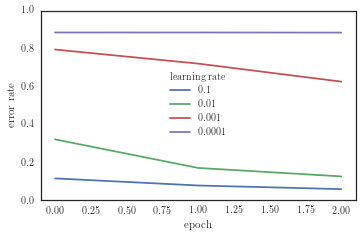

In [64]:
for learning_rate, error in error_per_learning_rate.items():
    plt.plot(error, label=learning_rate)
plt.legend(title='learning rate', loc='best')
plt.ylim((0, 1))
plt.xlabel('epoch')
plt.ylabel('error rate')

plt.savefig('../report/assets/error.pdf')
plt.show()

## Runtime CPU vs GPU

How does the number of parameters
change if you increase the number of filters? 

How does the runtime change? 

At last, run the same experiments again on a CPU, How does the plot change?

In [37]:
gpu_filters = [8, 16, 32, 64, 128, 256]
cpu_filters = [8, 16, 32, 64]

def check_time(filters, times):
    for n_filter in filters:
        start = time.time()
        # TODO: do something
        end = time.time()
        times.append(end - start)

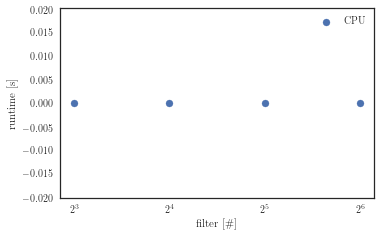

In [65]:
devices = device_lib.list_local_devices()
cpus = [d for d in devices if d.device_type == 'CPU']
gpus = [d for d in devices if d.device_type == 'GPU']

gpu_time = []
cpu_time = []

if len(cpus) > 0:
    with tf.device(cpus[0].name):
        check_time(cpu_filters, cpu_time)
    plt.scatter(cpu_filters, cpu_time, label='CPU')

if len(gpus) > 0:
    with tf.device(gpus[0].name):
        check_time(gpu_filters, gpu_time)
    plt.scatter(gpu_filters, gpu_time, label='GPU')
    
plt.legend(loc='best')
plt.xlabel('filter [\#]')
plt.xscale('log', basex=2)
plt.ylabel('runtime [s]')

plt.savefig('../report/assets/runtime.pdf')
plt.show()